In [18]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import os

batch_size = 128
num_classes = 10
epochs = 100
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# build our CNN model
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

# initiate Adam optimizer
opt = keras.optimizers.Adam()

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.


print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Fit the model on the batches generated by datagen.flow().
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4,
                    callbacks=[checkpoint, earlystop])

# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_103 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 30, 30, 128)       73856     
_________________________________________________________________
activation_104 (Activation)  (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
con

390/391 [============================>.] - ETA: 0s - loss: 0.8297 - acc: 0.7095
Epoch 00017: val_loss did not improve
391/391 [==============================] - 25s 63ms/step - loss: 0.8305 - acc: 0.7093 - val_loss: 0.6537 - val_acc: 0.7783
Epoch 18/100
388/391 [============================>.] - ETA: 0s - loss: 0.8230 - acc: 0.7126
Epoch 00018: val_loss improved from 0.63292 to 0.62795, saving model to /home/jovyan/saved_models/keras_cifar10_trained_model.h5
391/391 [==============================] - 21s 54ms/step - loss: 0.8237 - acc: 0.7126 - val_loss: 0.6279 - val_acc: 0.7816
Epoch 19/100
389/391 [============================>.] - ETA: 0s - loss: 0.8130 - acc: 0.7146
Epoch 00019: val_loss improved from 0.62795 to 0.60333, saving model to /home/jovyan/saved_models/keras_cifar10_trained_model.h5
391/391 [==============================] - 25s 64ms/step - loss: 0.8125 - acc: 0.7148 - val_loss: 0.6033 - val_acc: 0.7898
Epoch 20/100
390/391 [============================>.] - ETA: 0s - los

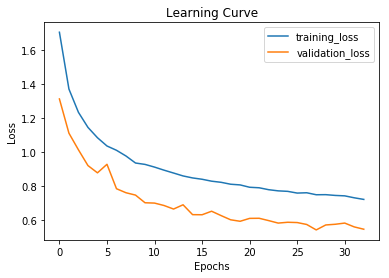

In [21]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()